In [177]:
import ee # earth engine 
ee.Initialize(project = "uhi-project-2025")

# define the interest area (Bucharest's approximate center and 10 km around it as a circle)
# roi = ee.Geometry.Point([26.1, 44.43]).buffer(10000) 
roi = ee.Geometry.Point([64.9864,-18]).buffer(5000)
# The data we are getting is based of Google Earth Engine tiff images
# (.tiff images are raster-format-based pictures that store values for any pixel. The values can represent temperatures, heights etc.,
# basically measurable units)

# the dataype we are working with is ee.Image -> a set of bands which, conceptually, are 2D matrices
# each band has a meaning: e.g. For Landsat 8 (which we'll be using, there are multiple bands. the 10th and 11th are 
# thermal bands). 

# our goal, first... to get a collection of tiff images from Google Earth Engine. 
# for that, we need to do some conversions. 

# 1. Calculate the LST. (Land Surface Temperature); It helps us to determine
# the labels for our model. Based on the temperature, we'll be having 3 labels: cold, moderate, hot. 

def calculate_lst(image: ee.Image) -> ee.Image: 
    # Select the 10th Landsat's thermal band 
    thermal_band = image.select("ST_B10")

    lst_celsius = thermal_band.subtract(273.15).rename('LST') # perform pixel-wise conversion K -> C and rename the band
    return image.addBands(lst_celsius)
 
# 2. Define the Urban Heat Island labels based on the LST band values
def label_classes(image: ee.Image): 
    # select the LST band 
    lst = image.select('LST')
    cold = lst.lt(25) # cold binary mask applied when temp is lower than 25 degrees celsius
    moderate = lst.gte(25).And(lst.lt(35))
    hot = lst.gte(35)

    # set the numerical labels based on the binary masks. 
    label_map = (cold.multiply(0)
                 .add(moderate.multiply(1))
                 .add(hot.multiply(2))
                 .rename('label'))
    
    return image.addBands(label_map)

# 3. Get the Landsat ee.Image items collection 
collection = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
            .filterBounds(roi) # inside our area of interest  
            .filter(ee.Filter.lt("CLOUD_COVER", 40)) # low cloud coverage
            .filterDate('2025-05-01', '2025-06-30')
            .map(calculate_lst) # applies the method defined before on EACH image of the collection 
            .map(label_classes)
            )

print(f"The number of images obtained: {collection.size().getInfo()}") # fetch the data from 
# the server to the local notebook :D

# We now need to export the features and the labels for our future model
def export_image(image: ee.Image, folder_name: str = "UHI_dataset"): 
    # save the images in the format: feature/label_{date}.tiff
    date_string = image.date().format('YYYYMMdd').getInfo()
    task1 = ee.batch.Export.image.toDrive(
        image = image.select('LST'), # select the LST band. 
        description = f"features_{date_string}",
        maxPixels = 1e13, 
        region = roi, 
        fileNamePrefix = f"features_{date_string}", 
        folder = folder_name, 
        scale = 30 # resolution in meters (30m is default for Landsat btw)
    )
    task1.start() 

    task2 = ee.batch.Export.image.toDrive(
        folder = folder_name, 
        fileNamePrefix = f"labels_{date_string}", 
        description = f"labels_{date_string}", 
        maxPixels = 1e13,
        scale = 30, 
        region = roi,
        image = image.select(['label'])
    )
    task2.start()

# run for a sample of 5 images let's say
images_list = collection.toList(collection.size())
for i in range(min(1, collection.size().getInfo())): 
    export_image(ee.Image(images_list.get(i)))

# .get() returns a proxy -> cast it into ee.Image to obtain the desired image 

print("Exports started. Check Google Drive after some time :).")

The number of images obtained: 0
Exports started. Check Google Drive after some time :).


   ---------------------------------------- 0.0/631.5 kB ? eta -:--:--
   ---------------------------------------- 631.5/631.5 kB 5.8 MB/s  0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 10.9 MB/s  0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 10.7 MB/s  0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 11.4 MB/s  0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 11.8 MB/s  0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 12.5 MB/s  0:00:00

   - --------------------------------------  1/22 [widgetsnbextension]
   ----- ----------------------------------  3/22 [scooby]
   ---

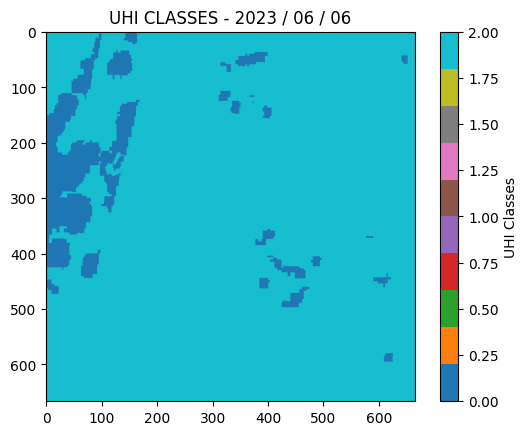

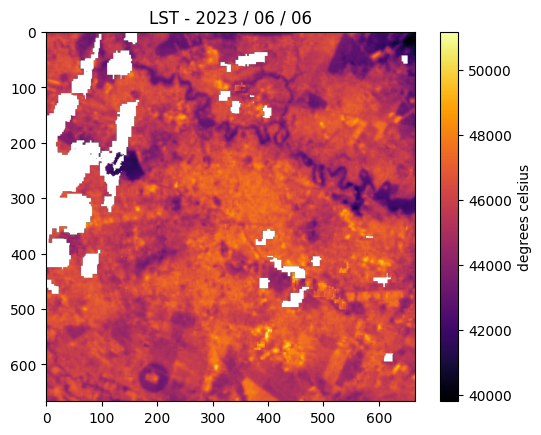

In [2]:
import rasterio
import matplotlib.pyplot as plt 
import numpy as np

with rasterio.open("labels_20230606.tif") as src: 
    label = src.read(1)
    plt.imshow(label, cmap = 'tab10', vmin = 0, vmax = 2)
    plt.title('UHI CLASSES - 2023 / 06 / 06')
    plt.colorbar(label = "UHI Classes")
    plt.show()

with rasterio.open("features_20230606.tif") as src: 
    lst = src.read(1)
    plt.imshow(lst, cmap = "inferno") # heatmap
    plt.colorbar(label = "degrees celsius")
    plt.title('LST - 2023 / 06 / 06')
    plt.show()


In [6]:
import rasterio 
from sklearn.feature_extraction import image as skimage
import numpy as np 

images = ["features_20230606.tif", "features_20230622.tif", "features_20230724.tif", "features_20230825.tif",
          "labels_20230606.tif", "labels_20230622.tif", "labels_20230724.tif", "labels_20230825.tif"]

lst = [] 
for image in images[:4]: 
    with rasterio.open(image) as src: 
        lst_img = src.read(1)
    lst.append(lst_img)
lst_stacked = np.stack(lst)

# print(lst_stacked.shape) -> 4 images, 667 x 666 resolution 

labels = []
for image in images[4:]: 
    with rasterio.open(image) as src: 
        labels_img = src.read(1)
    labels.append(labels_img)
labels_stacked = np.stack(labels)

# print(labels_stacked.shape) -> same as before 

patch_size = 64 
patches_per_image = 20000

lst_clean = np.nan_to_num(lst_stacked, nan = 0)
labels_clean = np.nan_to_num(labels_stacked, nan = 0)

lst_patches = [] 
for img in lst_clean: 
    lst_patch = skimage.extract_patches_2d(image = img, patch_size = (patch_size, patch_size), max_patches = patches_per_image)
    lst_patches.append(lst_patch)


labels_patches = []
for label in labels_clean: 
    label_patch = skimage.extract_patches_2d(image = label, patch_size = (patch_size, patch_size), max_patches = patches_per_image)
    labels_patches.append(label_patch)

# now we have two lists with patches, for both LST features and labels. We need to convert into numpy arrays 
lst_patches = np.vstack(lst_patches) 
labels_patches = np.vstack(labels_patches)

print(type(lst_patches)) # it returns numpy n dimension array. that is what we want. we will convert into pytorch tensors in the future! 

<class 'numpy.ndarray'>


In [4]:
print(type(lst))

<class 'numpy.ndarray'>


In [ ]:
print(labels_patches.shape) # 80000 patches, each having a resolution of 64 x 64 

(80000, 64, 64)


In [8]:
# convert the numpy arrays into pytorch tensors 
import torch 
lst_tensor_patches = torch.from_numpy(lst_patches).type(torch.float32)
labels_tensor_patches = torch.from_numpy(labels_patches).type(torch.float32)

In [9]:
print(type(lst_tensor_patches)) # -> torch.Tensor. 
lst_tensor_patches.shape

<class 'torch.Tensor'>


torch.Size([80000, 64, 64])

In [10]:
lst_tensor_patches.dtype # should be float32 

torch.float32

In [11]:
lst_tensor_patches = lst_tensor_patches.unsqueeze(1)
lst_tensor_patches.shape

torch.Size([80000, 1, 64, 64])

In [12]:
# convert the tensor patches into datasets
from torch.utils.data import TensorDataset
dataset = TensorDataset(lst_tensor_patches, labels_tensor_patches)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(f"There are {test_size} samples for testing")
print(f"There are {train_size} samples for training")

There are 16000 samples for testing
There are 64000 samples for training


In [13]:
from torch.utils.data import random_split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(len(train_dataset)) # it matches the train_size. 
print(f"For patch number 63999, the input data shape is {train_dataset[63999][0].shape} and the label associated shape is {train_dataset[63999][1].shape}")

64000
For patch number 63999, the input data shape is torch.Size([1, 64, 64]) and the label associated shape is torch.Size([64, 64])


In [14]:
# convert the datasets into dataloaders - which are iterables 
from torch.utils.data import DataLoader

torch.manual_seed(42)
BATCH_SIZE = 16 # compute the data into batches. 
# a single batch groups n different samples into one "package" -> this will lead to
# faster computation, better results 

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True) # it is considered good practice to shuffle the train data

test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False)

In [15]:
# check the outputs 
print(f"There are {len(train_dataloader)} training batches, each having {BATCH_SIZE} samples.")
len(train_dataloader) * BATCH_SIZE == train_size

There are 4000 training batches, each having 16 samples.


True

In [16]:
# see a sample from the dataloader 
image_batch, label_batch = next(iter(test_dataloader))
image_batch.shape # torch.Size([16, 1, 64, 64]) -> 16 samples, 1 color channel, each patch is 64 x 64. Great!

torch.Size([16, 1, 64, 64])

Text(0.5, 1.0, 'Display random sample')

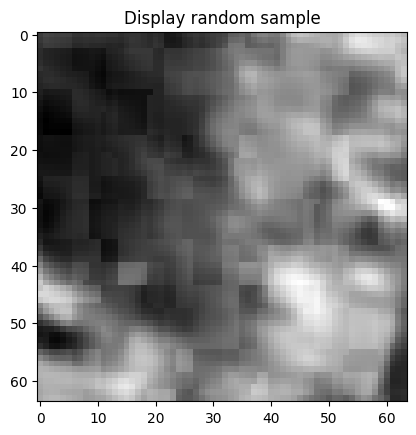

In [118]:
import matplotlib.pyplot as plt
random_idx = torch.randint(0, len(image_batch), size = [1]).item()
img, label = image_batch[random_idx], label_batch[random_idx]

plt.imshow(img.squeeze(), cmap = "gray")
plt.title("Display random sample")


In [119]:
from torch import nn

# replicate the TinyVGG arhitecture using semantic segmentation. 
class TinyVGG(nn.Module): 
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int): 
        super().__init__()
        # compressing the image, learning the general details such as textures or margins
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, 
                      out_channels = hidden_units, 
                      kernel_size = (3,3), # 3x3 matrix that slides over the processed image 
                      padding = 1, # frame width  
                      stride = 1), # how many pixels are shifted onwards

            nn.ReLU(), 
            nn.Conv2d(in_channels = hidden_units, 
                      out_channels = hidden_units, 
                      kernel_size= 3, 
                      padding = 1), # downsampling, feature extraction
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        # bottleneck learns the relationships at a smaller resolution, but more color channels
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units * 2, 
                      kernel_size = (3,3),
                      padding = 1), 
            nn.ReLU(), 
            nn.Conv2d(in_channels = hidden_units * 2,
                      out_channels = hidden_units * 2, 
                      kernel_size = 3, 
                      padding = 1), 
            nn.ReLU()
        )

        # rebuilding the image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = hidden_units * 2, 
                               out_channels = hidden_units,
                               kernel_size = 2, 
                               stride = 2, 
                               ), # upsampling 
            nn.ReLU(), 
            nn.Conv2d(in_channels = hidden_units, 
                      out_channels = output_shape, 
                      kernel_size = 1) # output logits: tensor like -> [B, num_classes, H, W]
        )      

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        # print(f'Initial shape: {x.shape}')

        x = self.encoder(x)
        # print(f"Shape after encoding: {x.shape}")

        x = self.bottleneck(x)
        # print(f"Shape after bottleneck: {x.shape}")

        x = self.decoder(x)
        # print(f"Shape after decoder: {x.shape}")

        return x 

In [120]:
# create an instance of the model 
model_0 = TinyVGG(input_shape = 1, 
                  output_shape = 3, 
                  hidden_units = 10)

# do a forward pass with some random data 
dummy_tensor = torch.rand([1,1,64,64])
model_0(dummy_tensor) # returns a tensor with 3 values -> which are logits for our three labels 
# in our training and test loop, we need to convert the logits into real probabilities. 

# RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1690 and 490x3)
# modify the in_features after the flattening layer in the model class

tensor([[[[0.2941, 0.2956, 0.2944,  ..., 0.2940, 0.2935, 0.2953],
          [0.2960, 0.2985, 0.2969,  ..., 0.2989, 0.2973, 0.2997],
          [0.2943, 0.2950, 0.2950,  ..., 0.2935, 0.2936, 0.2933],
          ...,
          [0.2966, 0.2976, 0.2980,  ..., 0.2977, 0.2988, 0.2981],
          [0.2959, 0.2945, 0.2952,  ..., 0.2936, 0.2952, 0.2934],
          [0.2980, 0.2988, 0.2993,  ..., 0.2985, 0.2988, 0.2986]],

         [[0.0731, 0.0717, 0.0733,  ..., 0.0720, 0.0725, 0.0711],
          [0.0726, 0.0728, 0.0724,  ..., 0.0726, 0.0729, 0.0718],
          [0.0733, 0.0721, 0.0739,  ..., 0.0725, 0.0726, 0.0723],
          ...,
          [0.0726, 0.0732, 0.0727,  ..., 0.0732, 0.0729, 0.0725],
          [0.0727, 0.0724, 0.0733,  ..., 0.0726, 0.0730, 0.0725],
          [0.0721, 0.0725, 0.0718,  ..., 0.0727, 0.0725, 0.0719]],

         [[0.2359, 0.2312, 0.2366,  ..., 0.2323, 0.2338, 0.2292],
          [0.2342, 0.2350, 0.2337,  ..., 0.2342, 0.2353, 0.2315],
          [0.2365, 0.2326, 0.2384,  ..., 0

In [121]:
# define a loss function and an optimizer 
# since my model is about a multi-class classification which takes images as inputs, a cross-entropy-based function is suitable 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), 
                             lr = 0.01) # learnin' rate 

# define evaluation metrics
def accuracy_fn(y_true, y_pred): 
    correct = torch.eq(y_true, y_pred).sum().item() # count the correct predicted items 
    total = torch.numel(y_true)
    return correct / total * 100


In [123]:
from tqdm.auto import tqdm # dinamic loading bar 

# set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.manual_seed(42)
torch.manual_seed(42)

# build the train step and the test step. 
# both of them will be called during each epoch

def train_step(model: nn.Module, 
               device: torch.device, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    
    # since our computation is made on batches, we also might need to calculate the loss and accuracy PER BATCH
    train_loss, train_accuracy = 0,0
    for batch, (X_train, y_train) in enumerate(dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device).long()

        # set the model to training mode
        model.train()

        # do the forward pass 
        y_training_logits = model(X_train)
    
        # perform conversion: logits -> prediction probabilities
        y_prediction_probs = torch.softmax(y_training_logits, dim = 1)
        # softmax is a function that turns the numbers into probabilities that sum up to 1 

        # perform conversion: prediction probabilities -> prediction labels 
        y_preds = torch.argmax(y_prediction_probs, dim = 1) # takes the value and rounds it to the closest integer 

        # calculate the loss
        loss = loss_fn(y_training_logits, y_train)
        train_loss += loss

        # calculate the accuracy 
        accuracy = accuracy_fn(y_train, y_preds)
        train_accuracy += accuracy

        # disable gradient tracking for the optimizer
        optimizer.zero_grad()

        # perform the backpropagation with respect to the model's parameters 
        loss.backward()

        # do the gradient descent, with the advantage that we compute data per batch, not per epoch, so quicker updates to the parameters made by the optimizer
        optimizer.step()

        if (batch % 400 == 0): 
            print(f"Looked at {batch * len(X_train)} / {len(dataloader.dataset)} samples.")

    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)

    print(f"Train loss: {train_loss:.5f} | Train_acc: {train_accuracy:.2f}%")

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              accuracy_fn, 
              device: torch.device): 
    # again, calculate the accuracy and the loss per batch

    test_loss= 0
    test_accuracy = 0

    # set the model to test mode 
    model.eval() 
    with torch.inference_mode(): 
        for X_test, y_test in dataloader: 
            X_test, y_test = X_test.to(device), y_test.to(device).long() 

            y_test_logits = model(X_test)
            y_prediction_probs = torch.softmax(y_test_logits, dim = 1)
            y_preds = torch.argmax(y_prediction_probs, dim = 1)
            
            loss = loss_fn(y_test_logits, y_test)
            test_loss += loss 

            accuracy = accuracy_fn(y_test, y_preds)
            test_accuracy += accuracy

        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)
        
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}%")

In [124]:
# build the training and testing loop for a specific number of epochs 

epochs = 5 

for epoch in tqdm(range(epochs)): 
    print(f"Epoch number {epoch}")
    train_step(model = model_0, 
               device = device, 
               dataloader = train_dataloader, 
               loss_fn = loss_fn, 
               optimizer = optimizer, 
               accuracy_fn = accuracy_fn)
    
    test_step(model = model_0, 
              dataloader = test_dataloader,
              loss_fn = loss_fn, 
              accuracy_fn = accuracy_fn, 
              device = device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch number 0
Looked at 0 / 64000 samples.
Looked at 6400 / 64000 samples.
Looked at 12800 / 64000 samples.
Looked at 19200 / 64000 samples.
Looked at 25600 / 64000 samples.
Looked at 32000 / 64000 samples.
Looked at 38400 / 64000 samples.
Looked at 44800 / 64000 samples.
Looked at 51200 / 64000 samples.
Looked at 57600 / 64000 samples.
Train loss: 0.36486 | Train_acc: 93.26%
Test loss: 0.24356 | Test accuracy: 93.40%
Epoch number 1
Looked at 0 / 64000 samples.
Looked at 6400 / 64000 samples.
Looked at 12800 / 64000 samples.
Looked at 19200 / 64000 samples.
Looked at 25600 / 64000 samples.
Looked at 32000 / 64000 samples.
Looked at 38400 / 64000 samples.
Looked at 44800 / 64000 samples.
Looked at 51200 / 64000 samples.
Looked at 57600 / 64000 samples.
Train loss: 0.24448 | Train_acc: 93.39%
Test loss: 0.24335 | Test accuracy: 93.40%
Epoch number 2
Looked at 0 / 64000 samples.
Looked at 6400 / 64000 samples.
Looked at 12800 / 64000 samples.
Looked at 19200 / 64000 samples.
Looked at 25

In [140]:
import rasterio
import numpy as np

# exemplu: citim o imagine TIFF
with rasterio.open("features_20230622.tif") as src:
    full_image = src.read()  # shape: (bands, height, width)

print(type(full_image))
print(full_image.shape) # -> (num_image, height, width)

<class 'numpy.ndarray'>
(1, 667, 666)


In [141]:
# define a function to extract the patches 
from typing import Tuple, List
def extract_patches(image: np.ndarray, patch_size: int = 64) -> Tuple[np.ndarray, List[Tuple[int, int]]]: 
    """Takes an image and splits it into mutiple patches, returns a tuple of the patches and the positions 
    for each patch."""
    _, height, width = image.shape
    patches = []
    positions = []

    # loop through patches like in a matrix
    for i in range(0, height - patch_size + 1, patch_size): 
        for j in range(0, width - patch_size + 1, patch_size): 
            patch = image[:, i:i + patch_size, j:j + patch_size]
            patches.append(patch)
            positions.append((i,j))
    
    return np.array(patches), positions 

patches, positions = extract_patches(full_image, patch_size = 64)    

In [142]:
type(patches) # numpy array -> convert into pytorch tensor

patches_tensor = torch.from_numpy(patches).type(torch.float32)
print(patches_tensor.shape) # 100 patches, 1 color channel, 64 x 64 res

torch.Size([100, 1, 64, 64])


In [143]:
# make prediction for each patch 
model_0.eval()

predictions = []
with torch.inference_mode(): 
    for patch in patches_tensor: 
        patch = patch.unsqueeze(0).to(device)
        y_logits = model_0(patch)
        y_pred_probs = torch.softmax(y_logits, dim = 1)
        y_preds = torch.argmax(y_pred_probs, dim = 1)
        y_preds = y_preds.squeeze(0).numpy() # eliminate from the batch, convert to numpy
        predictions.append(y_preds)


In [144]:
_, height, width = full_image.shape
uhi_map = np.zeros((height, width))

for (i,j), pred in zip(positions, predictions): 
    uhi_map[i:i+patch_size, j:j+patch_size] = pred  

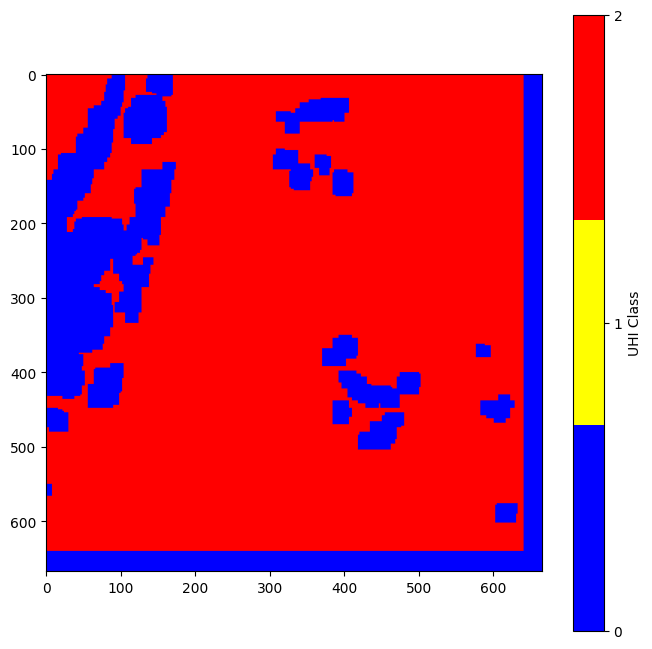

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# define colors: cold=blue, moderate=yellow, hot=red
colors = ['blue', 'yellow', 'red']
cmap = ListedColormap(colors)

plt.figure(figsize=(8,8))
plt.imshow(uhi_map, cmap=cmap)
plt.colorbar(ticks=[0,1,2], label='UHI Class')
plt.show()

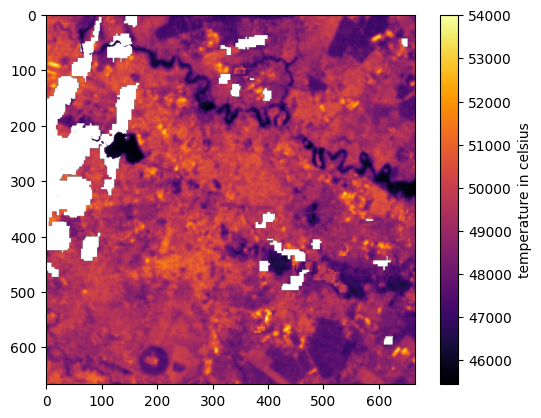

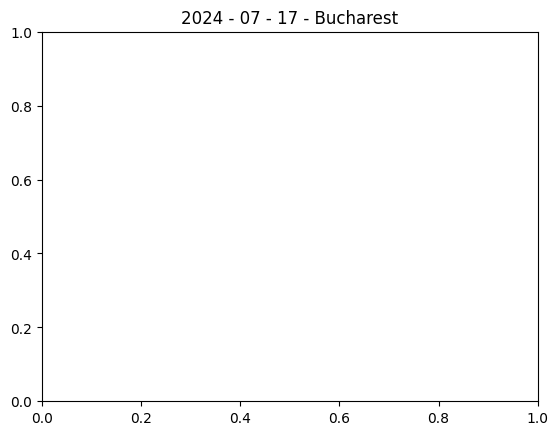

In [168]:
import rasterio
with rasterio.open("features_20240717.tif") as src: 
    full_image = src.read(1) 
    plt.imshow(full_image, cmap = "inferno") 
    plt.colorbar(label = "temperature in celsius")
    plt.show()
    plt.title("2024 - 07 - 17 - Bucharest")     

